<a href="https://colab.research.google.com/github/Dev-180Memes/clustering-comparison/blob/main/Clustering_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow numpy scikit-learn pandas matplotlib seaborn

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
data = np.concatenate([x_train, x_test], axis=0)
labels = np.concatenate([y_train, y_test], axis=0)

In [5]:
data = data.reshape(data.shape[0], -1)

In [6]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
data = pca.fit_transform(data)
print(f"Reduced data shape: {data.shape}")

Reduced data shape: (70000, 50)


In [8]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

In [9]:
n_clusters = 10
random_state = 42
batch_size = 1000

In [10]:
results = []

In [11]:
def evaluate_clustering(data, labels, clusters, algo_name, exec_time):
    silhouette = silhouette_score(data, clusters, sample_size=10000)
    ari = adjusted_rand_score(labels, clusters)
    nmi = normalized_mutual_info_score(labels, clusters)
    return {
        'Algorithm': algo_name,
        'Execution Time': exec_time,
        'Silhouette Score': silhouette,
        'Adjusted Rand Index': ari,
        'Normalized Mutual Information': nmi
    }

In [12]:
import time

In [13]:
kmeans_inertia = []
mini_batch_inertia = []

In [15]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1, n_init=1, random_state=random_state)
kmeans.fit(data)
kmeans_inertia.append(kmeans.inertia_)
init_centroids = kmeans.cluster_centers_

In [16]:
start_time = time.time()
for i in range(19):  # already ran 1 above
    kmeans = KMeans(n_clusters=n_clusters, init=init_centroids, max_iter=1, n_init=1, random_state=random_state)
    kmeans.fit(data)
    kmeans_inertia.append(kmeans.inertia_)
    init_centroids = kmeans.cluster_centers_
exec_time = time.time() - start_time
kmeans_cluster = kmeans.predict(data)
results.append(evaluate_clustering(data, labels, kmeans_cluster, 'K-Means', exec_time))

In [17]:
mini_batch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', random_state=random_state, batch_size=batch_size)
start_time = time.time()
for i in range(20):
    mini_batch_kmeans.partial_fit(data)
    mini_batch_inertia.append(mini_batch_kmeans.inertia_)
exec_time = time.time() - start_time
mini_batch_kmeans_cluster = mini_batch_kmeans.predict(data)
results.append(evaluate_clustering(data, labels, mini_batch_kmeans_cluster, 'Mini-Batch K-Means', exec_time))

In [18]:
result_df = pd.DataFrame(results)
result_df

,Algorithm,Execution Time,Silhouette Score,Adjusted Rand Index,Normalized Mutual Information
0,K-Means,3.737555,0.055621,0.270489,0.394703
1,Mini-Batch K-Means,1.853499,0.055888,0.285674,0.404142


In [19]:
from sklearn.metrics import davies_bouldin_score

In [20]:
kmeans_db = davies_bouldin_score(data, kmeans_cluster)
mini_batch_kmeans_db = davies_bouldin_score(data, mini_batch_kmeans_cluster)

In [21]:
results[0]['Davies-Bouldin Index'] = kmeans_db
results[1]['Davies-Bouldin Index'] = mini_batch_kmeans_db

In [22]:
results_df = pd.DataFrame(results)
results_df

,Algorithm,Execution Time,Silhouette Score,Adjusted Rand Index,Normalized Mutual Information,Davies-Bouldin Index
0,K-Means,3.737555,0.055621,0.270489,0.394703,2.568086
1,Mini-Batch K-Means,1.853499,0.055888,0.285674,0.404142,2.536877


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [24]:
pca_2d = PCA(n_components=2)
data_2d = pca_2d.fit_transform(data)

In [25]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

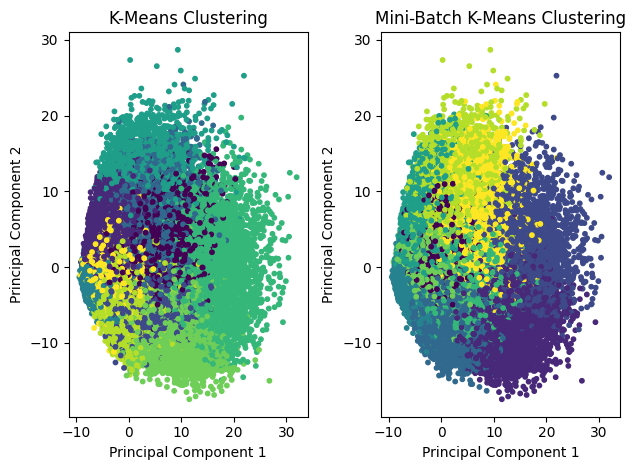

In [26]:
plt.subplot(1, 2, 1)
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=kmeans_cluster, cmap='viridis', s=10)
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.subplot(1, 2, 2)
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=mini_batch_kmeans_cluster, cmap='viridis', s=10)
plt.title('Mini-Batch K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

In [27]:
results_df

,Algorithm,Execution Time,Silhouette Score,Adjusted Rand Index,Normalized Mutual Information,Davies-Bouldin Index
0,K-Means,3.737555,0.055621,0.270489,0.394703,2.568086
1,Mini-Batch K-Means,1.853499,0.055888,0.285674,0.404142,2.536877


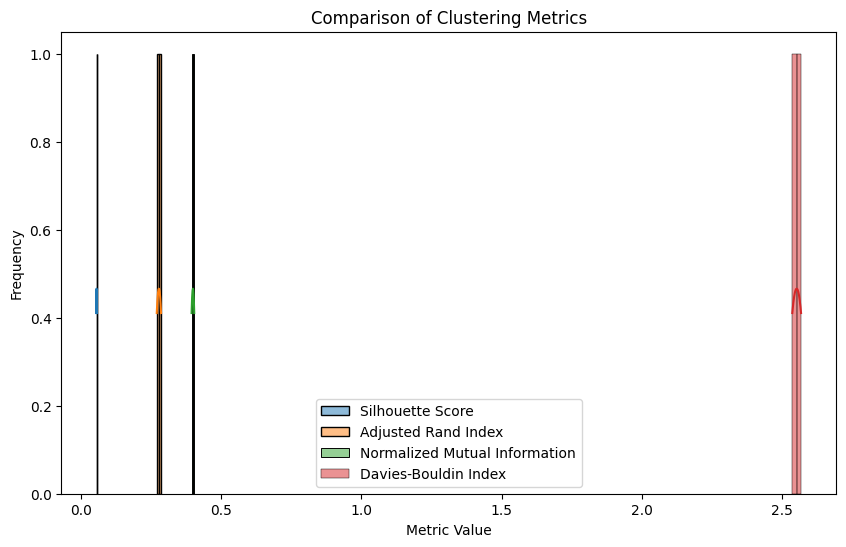

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for column in ['Silhouette Score', 'Adjusted Rand Index', 'Normalized Mutual Information', 'Davies-Bouldin Index']:
    sns.histplot(results_df[column], label=column, kde=True)
plt.title('Comparison of Clustering Metrics')
plt.xlabel('Metric Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


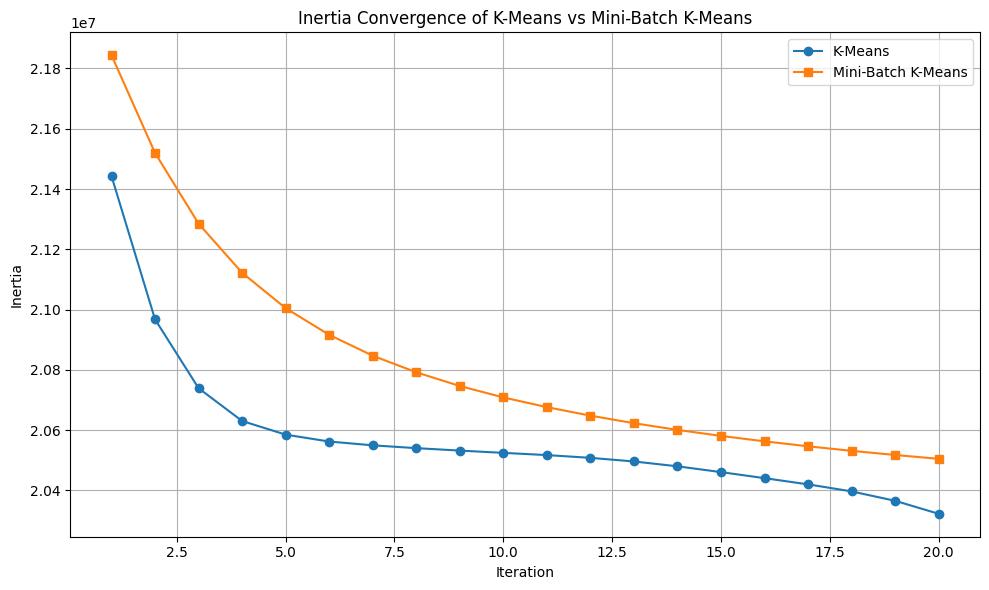

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), kmeans_inertia, label='K-Means', marker='o')
plt.plot(range(1, 21), mini_batch_inertia, label='Mini-Batch K-Means', marker='s')
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.title('Inertia Convergence of K-Means vs Mini-Batch K-Means')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()